# parcels regions

runs parcels on existing netcdf files

In [11]:
%matplotlib inline

In [12]:
import json
import math
import os
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet
from parcels import AdvectionRK4
from datetime import timedelta, datetime

# ignore annoying deprecation warnings
import warnings
warnings.simplefilter("ignore", UserWarning)
import cartopy

# ignore divide by nan error that happens constantly with parcels
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [13]:
DATA_6KM = 6
DATA_2KM = 2
DATA_1KM = 1

filename_dict = {
    DATA_6KM: "west_coast_6km_hourly",
    DATA_2KM: "west_coast_2km_hourly",
    DATA_1KM: "west_coast_1km_hourly"
}

def get_file_info(name, path, res, parcels_cfg):
    """
    Args:
        name (str)
        path (str)
        res (int)
        parcels_cfg (dict)
    """
    xrds = xr.open_dataset(path)
    # spherical mesh
    fs = FieldSet.from_xarray_dataset(
            xrds.copy(deep=True),
            dict(U="u",V="v"),
            dict(lat="lat",lon="lon",time="time")
        )
    xrds.close()
    lat = xrds["lat"].values
    lon = xrds["lon"].values
    return dict(
        name = name,
        path = path,
        res = res,
        xrds = xrds,
        fs = fs,
        timerng = (xrds["time"].min().values, xrds["time"].max().values),
        timerng_secs = fs.gridset.dimrange("time"),
        lat = lat,
        lon = lon,
        domain = {
            "S": lat.min(),
            "N": lat.max(),
            "W": lon.min(),
            "E": lon.max(),
        },
        cfg = parcels_cfg
    )

def load_config(path):
    with open(path) as f:
        config = json.load(f)
    # TODO do some config verification here
    return config

In [14]:
configs = [
    "parcels_configs/tijuana_lin_cfg.json"
]

loaded_configs = [load_config(path) for path in configs]
files = [get_file_info(cfg["name"], cfg["netcdf_path"], cfg["resolution"], cfg["parcels_config"]) for cfg in loaded_configs]

## Animated gif stuff and particle simulation

runs on each file you give it

In [15]:
# animation man very cool
# reference tutorial_Agulhasparticles
# needs ErrorCode for particle recovery
from operator import attrgetter
from parcels import ErrorCode, JITParticle, Variable

max_v = 1.1 # for display purposes only, so the vector field colors don't change every iteration

class TimedParticle(JITParticle):
    lifetime = Variable("lifetime", initial=0, dtype=np.float32)
    spawntime = Variable("spawntime", initial=attrgetter("time"), dtype=np.float32)
    
def ParticleLifetime(particle, fieldset, time):
    particle.lifetime += particle.dt

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def exec_save_pset(data, i, runtime, dt, zpad = 3, save_snapshot = True, exec_pset = True):
    """
    Saves a snapshot of a particle simulation and then executes.
    
    Args:
        data (dict)
        i (int)
        runtime (float): seconds
        dt (float): seconds
    """
    if save_snapshot:
        data["pset"].show(savefile=str(data["snap_path"])+"/particles"+str(i).zfill(zpad), field="vector", vmax=max_v)
    
    if exec_pset:
        # temporary - TODO make it only init once
        k_plifetime = data["pset"].Kernel(ParticleLifetime)

        data["pset"].execute(
            AdvectionRK4 + k_plifetime,
            runtime=timedelta(seconds=runtime),
            dt=timedelta(seconds=dt),
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
            output_file=data["pfile"]
        )

### particle simulation setup and execution

reads from each config and executes a simulation from each settings

note about interpolation methods: only `linear` works if you want to use the FieldSet in a ParticleSet.

In [16]:
part_path = Path("particledata")
part_path.mkdir(parents=True, exist_ok=True)

for f in files:
    cfg = f["cfg"]
    repeat_dt = timedelta(seconds=cfg["repeat_dt"]) # interval at which particles are released
    particles_per_dt = cfg["particles_per_dt"] # number of particles to release at each interval
    max_variation = cfg["max_variation"] # the max degrees a particle can be away from a spawn point
    spawn_points = np.array(cfg["spawn_points"]) # particle spawns will be randomly chosen between these points
    
    repetitions = math.floor(f["timerng_secs"][1] / repeat_dt.total_seconds())
    total = repetitions * particles_per_dt
    lat_arr = np.zeros(total)
    lon_arr = np.zeros(total)
    time_arr = np.zeros(total)
    for i in range(repetitions):
        time_arr[particles_per_dt * i:particles_per_dt * (i + 1)] = repeat_dt.total_seconds() * i

    sp_lat = spawn_points.T[0][np.random.randint(0, len(spawn_points), total)]
    sp_lon = spawn_points.T[1][np.random.randint(0, len(spawn_points), total)]
    variances_lat = (np.random.random(total) * 2 - 1) * max_variation
    variances_lon = (np.random.random(total) * 2 - 1) * max_variation

    p_lats = sp_lat + variances_lat
    p_lons = sp_lon + variances_lon

    # set up ParticleSet and ParticleFile
    f["pset"] = ParticleSet(fieldset=f["fs"], pclass=TimedParticle, lon=p_lons, lat=p_lats, time=time_arr)
    save_path = f"{part_path}/particle_{f['name']}.nc"
    f["pfile"] = f["pset"].ParticleFile(save_path)
    print(f"Particle trajectories for {f['name']} will be saved to {save_path}")
    
    snapshot_interval = cfg["snapshot_interval"] # seconds, determines how often to take a snapshot of the simulation
    p_dt = cfg["simulation_dt"] # seconds, determines the dt of the simulation itself (does not impact snapshot interval)
    save_snap = cfg["save_snapshots"] # whether to save snapshots of the simulation for gif generation later
    
    ################################################
    # setting up times, intervals, and paths for simulation
    snap_num = math.floor((f["timerng_secs"][1] - f["timerng_secs"][0]) / snapshot_interval)
    last_int = f["timerng_secs"][1] - snap_num * snapshot_interval
    if last_int == 0:
        print(f"Num snapshots to save for {f['path']}: {snap_num + 1}")
    else:
        print(f"Num snapshots to save for {f['path']}: {snap_num + 2}")
    f["snap_path"] = Path(f"snapshots_{filename_dict[f['res']]}/{f['name']}")
    f["snap_path"].mkdir(parents=True, exist_ok=True)
    print(f"Path to save snapshots to: {f['snap_path']}")
    # only clear directory if desired or actually saving images
    if save_snap:
        for p in f["snap_path"].glob("*.png"):
            p.unlink()
          
    ################################################
    # execution of simulation
    for i in range(snap_num):
        exec_save_pset(f, i, snapshot_interval, p_dt, save_snapshot=save_snap)

    # save the second-to-last frame
    exec_save_pset(f, snap_num, 0, 0, save_snapshot=save_snap, exec_pset=False)

    # run the last interval (the remainder) if needed
    if last_int != 0:
        exec_save_pset(f, snap_num + 1, last_int, p_dt, save_snapshot=save_snap)
        
    f["pfile"].export()
    f["pfile"].close()

print("all simulations done and snapshots saved (if simulation was saving snapshots)")

Particle trajectories for tijuana_lin will be saved to particledata/particle_tijuana_lin.nc
Num snapshots to save for west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc: 57
Path to save snapshots to: snapshots_west_coast_1km_hourly/tijuana_lin


INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/a89655c927ade1e38b7d2898850113b8_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/69e174d334424e5ad58be31ccb91c20f_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/cccf7d0887d2df67e5926267d6a42cc8_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/079cb55a721d29dd58b3bf1ef7196d98_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/f77bfd9ac0cee446c485f8555bf60121_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/d4437e44454bd1307bc71090db6a1f08_0.so
INFO: Compiled TimedParticleAdvectionRK4

INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/704240138cc59d4ce167c72b574f940a_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/e1805f2a23c0e152bed420194cc67307_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/cc6482aca0e439396819e80a801fb07b_0.so
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/7a729354e34eb5406266cdc6273564ce_0.so


all simulations done and snapshots saved (if simulation was saving snapshots)


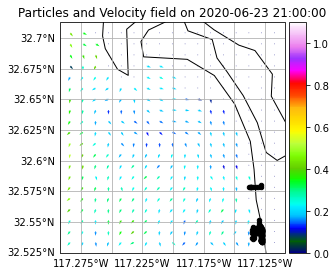

[None]

In [7]:
[f["pset"].show(field="vector", vmax=max_v) for f in files]

### gif generation

don't have to run, requires [magick](https://imagemagick.org/index.php)

the gifs will be saved `snapshots_west_coast_xkm_hourly/` where xkm is the resolution

In [8]:
import subprocess

gif_delay = 25 # ms

if save_snap:
    for f in files:
        magick_sp = subprocess.Popen(["magick", "-delay", str(gif_delay), str(f["snap_path"]) + "/*.png", f"snapshots_{filename_dict[f['res']]}/partsim_{f['name']}.gif"], 
                                       stdout=subprocess.PIPE,
                                       stderr=subprocess.PIPE,
                                       universal_newlines=True)
        stdout, stderr = magick_sp.communicate()
        print((stdout, stderr))

('', '')
